# Regularized Regression Practice

Why regularize?

- Reduce complexity
- Reduce the chance of overfitting
- Reduce model variance at the expense of introducing small bias
- Increase model interpretability

What even is L1 or L2?

### Review:

What is L1 Regularization (LASSO) good for?

- feature selection


What is L2 Regularization (Ridge) good for?

- reduce multicollinearity


In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

![baby penguin gif from Giphy](https://media.giphy.com/media/RiJuDMqd6vDgfPrZN2/giphy.gif)

Let's hang out with penguins some more:

In [2]:
data = sns.load_dataset('penguins')

In [3]:
data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Let's clean up this dataset - two rows have quite a few null values, and 11 total do not have a value for `sex`, so let's drop rows where any data is null:

In [6]:
# Drop nulls here
data = data.dropna(how = 'any')

In [7]:
# Sanity check
data.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   culmen_length_mm   333 non-null    float64
 3   culmen_depth_mm    333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


### Encoding Our Data

In [9]:
data[['species','island','sex']].describe()

,species,island,sex
count,333,333,333
unique,3,3,2
top,Adelie,Biscoe,MALE
freq,146,163,168


In order to use the `gender`, `species` or `island` data we need to render those strings as numbers - since there are only 2-3 unique values per column, let's simply one-hot-encode those columns (aka turn the columns into a series of binary indicators).

Using Pandas' `get_dummies` : https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.get_dummies.html

In [11]:
# One hot encode our three 'object' columns
data_num = pd.get_dummies(data, columns = ['species','island','sex'], drop_first = True)

# dummies = ohe.fit_transform(X_train[['species', 'island', 'sex']])


In [12]:
data_num.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_MALE
0,39.1,18.7,181.0,3750.0,0,0,0,1,1
1,39.5,17.4,186.0,3800.0,0,0,0,1,0
2,40.3,18.0,195.0,3250.0,0,0,0,1,0
4,36.7,19.3,193.0,3450.0,0,0,0,1,0
5,39.3,20.6,190.0,3650.0,0,0,0,1,1


You'll note that Pandas' `get_dummies` does not automatically drop one of the columns - even though the two `sex` columns, `sex_FEMALE` and `sex_MALE`, are simply inverses of each other, and thus one of those columns contains the same amount of information as having both of those columns, it keeps both. That's fine for now.

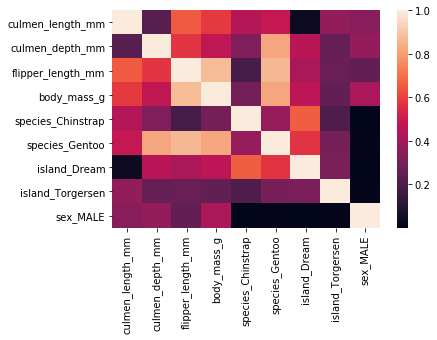

In [13]:
sns.heatmap(data_num.corr().abs())
plt.show()

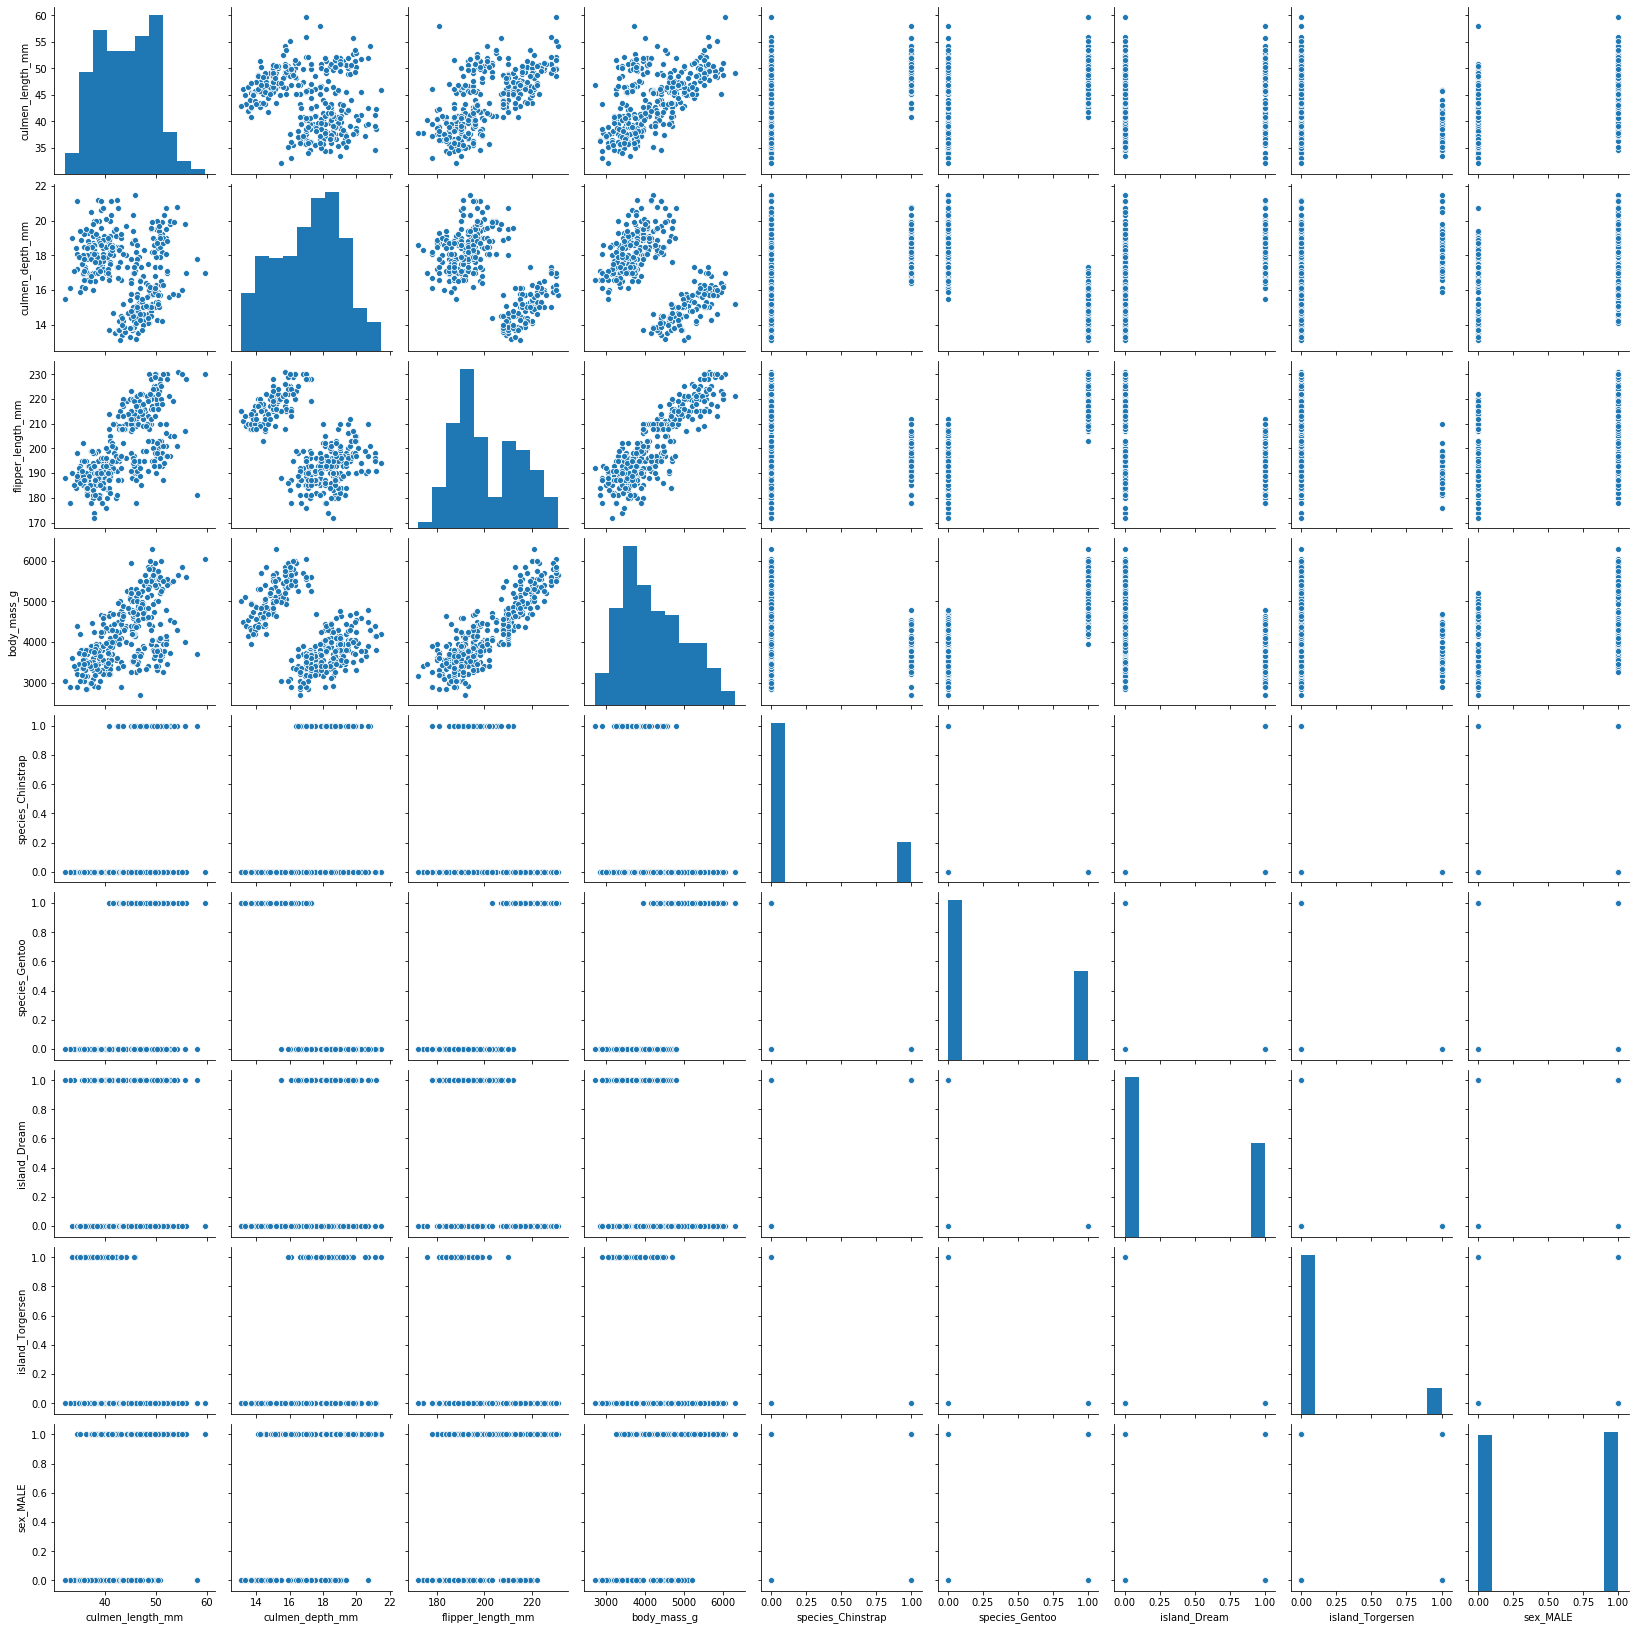

In [14]:
sns.pairplot(data_num)

The goal of this is to predict body mass, `body_mass_g`, so let's define our X and y and perform a train/test split:

In [36]:
# Define X and y
X = data_num.drop(columns = 'body_mass_g')
y = data_num['body_mass_g']

In [37]:
# Perform a train/test split
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [38]:
len(X_test) + len(X_train) == len(X)

True

### Scaling our Data:

When we introduced scaling variables last week, we talked about how some models require that we scale or standardize variables before using those models - Ridge and LASSO regression are two of those models!

Why? Because both Ridge and LASSO look at the coefficients of a linear regression model to penalize those coefficients. Coefficients of linear models are highly dependent on the values of those models - making sure they're properly scaled will make sure that our model penalizes actually useless columns, instead of just thinking those columns are useless because the data isn't properly scaled.

In [39]:
# Instantiate a scaler
scaler = StandardScaler()

In [40]:
# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Baseline Linear Regression Model

In [41]:
# Instantiate a linear regression model
lr = LinearRegression()

In [42]:
# Fit our model on our scaled data
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
# Evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")

Training Scores:
R2: 0.8656366816067811
Mean Absolute Error: 224.23646904644232
---
Testing Scores:
R2: 0.8815112350060905
Mean Absolute Error: 234.63492388775887


### L1 Norm: LASSO

In [44]:
# Instantiate a lasso regression model
lasso = Lasso(alpha = .5)

In [45]:
# Fit your new L1 model -  on the scaled data
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [46]:
# Evaluate=
y_train_pred_l1 = lasso.predict(X_train_scaled)
y_test_pred_l1 = lasso.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred_l1)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_l1)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred_l1)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_l1)}")

Training Scores:
R2: 0.8656297288399611
Mean Absolute Error: 224.35428092118863
---
Testing Scores:
R2: 0.881678761760279
Mean Absolute Error: 234.37263782493383


Remember - what's the benefit of using LASSO?

In [47]:
data_num.columns

Index(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'species_Chinstrap', 'species_Gentoo', 'island_Dream',
       'island_Torgersen', 'sex_MALE'],
      dtype='object')

In [48]:
print("Unpenalized Linear Regression Coefficients are:{}".format(lr.coef_))
print("Unpenalized Linear Regression Intercept:{}".format(lr.intercept_))
print("---")
print("Lasso Regression Coefficients are:{}".format(lasso.coef_))
print("Lasso Linear Regression Intercept:{}".format(lasso.intercept_))

Unpenalized Linear Regression Coefficients are:[  87.22142199  158.26711921  198.34850626 -107.66212777  478.93391517
  -15.87905258  -38.06622252  177.63639787]
Unpenalized Linear Regression Intercept:4129.819277108434
---
Lasso Regression Coefficients are:[  85.72045485  154.67263095  199.35983111 -106.25523764  476.33227928
  -15.35114967  -37.36367155  178.85936749]
Lasso Linear Regression Intercept:4129.819277108434


### L2 Norm: Ridge

In [49]:
# Instantiate a lasso regression model
ridge = Ridge(alpha = .5)

In [50]:
# Fit your new L2 model -  on the scaled data
ridge.fit(X_train_scaled, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [51]:
# Evaluate
y_train_pred_l2 = ridge.predict(X_train_scaled)
y_test_pred_l2 = ridge.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred_l2)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_l2)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred_l2)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_l2)}")

Training Scores:
R2: 0.8656200313343904
Mean Absolute Error: 224.22463894701843
---
Testing Scores:
R2: 0.8817475404291851
Mean Absolute Error: 234.3225028660636


In [52]:
print("Unpenalized Linear Regression Coefficients are:{}".format(lr.coef_))
print("Unpenalized Linear Regression Intercept:{}".format(lr.intercept_))
print("---")
print("Ridge Regression Coefficients are:{}".format(ridge.coef_))
print("Ridge Linear Regression Intercept:{}".format(ridge.intercept_))

Unpenalized Linear Regression Coefficients are:[  87.22142199  158.26711921  198.34850626 -107.66212777  478.93391517
  -15.87905258  -38.06622252  177.63639787]
Unpenalized Linear Regression Intercept:4129.819277108434
---
Ridge Regression Coefficients are:[  89.74310496  152.54025768  201.5486011  -109.65068519  467.77035148
  -17.56155692  -39.00707182  177.99049154]
Ridge Linear Regression Intercept:4129.819277108434


All together:

In [53]:
coef_dict = {}
for loc, col in enumerate(data_num.columns):
    coef_dict[col] = {"Unpenalized": lr.coef_[loc-1],
                      "LASSO": lasso.coef_[loc-1],
                      "Ridge": ridge.coef_[loc-1]}
pd.DataFrame.from_dict(coef_dict)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_MALE
Unpenalized,177.636398,87.221422,158.267119,198.348506,-107.662128,478.933915,-15.879053,-38.066223,177.636398
LASSO,178.859367,85.720455,154.672631,199.359831,-106.255238,476.332279,-15.351150,-37.363672,178.859367
Ridge,177.990492,89.743105,152.540258,201.548601,-109.650685,467.770351,-17.561557,-39.007072,177.990492


### Alpha Levels??

We started with the **hyperparameter** alpha set to `0.5` for both our LASSO and Ridge Models: now let's play around with it!

In [55]:
alphas = [.25, .5, 1, 10, 50, 100]

In [62]:
for a in alphas:
    lasso_test = Lasso(alpha = a)
    lasso_test.fit(X_train_scaled, y_train)
    y_train_pred_test = lasso_test.predict(X_train_scaled)
    y_test_pred_test = lasso_test.predict(X_test_scaled)

    print(f"Training Scores at alpha: {a}")
    print(f"R2: {r2_score(y_train, y_train_pred_test)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_test)}")
    print("---")
    print(f"Testing Scores at alpha: {a}")
    print(f"R2: {r2_score(y_test, y_test_pred_test)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_test)}")
    print("---")
    print(f"coefficient at {a} are: {lasso_test.coef_}")
    print(f"intercept at {a} is: {lasso_test.intercept_}")
    print("~" * 20)

Training Scores at alpha: 0.25
R2: 0.86563493828738
Mean Absolute Error: 224.29546981933964
---
Testing Scores at alpha: 0.25
R2: 0.8815970087111513
Mean Absolute Error: 234.50301081007905
---
coefficient at 0.25 are: [  86.48052913  156.46100122  198.86802068 -106.97101991  477.60653883
  -15.61367571  -37.71537023  178.24449256]
intercept at 0.25 is: 4129.819277108434
~~~~~~~~~~~~~~~~~~~~
Training Scores at alpha: 0.5
R2: 0.8656297288399611
Mean Absolute Error: 224.35428092118863
---
Testing Scores at alpha: 0.5
R2: 0.881678761760279
Mean Absolute Error: 234.37263782493383
---
coefficient at 0.5 are: [  85.72045485  154.67263095  199.35983111 -106.25523764  476.33227928
  -15.35114967  -37.36367155  178.85936749]
intercept at 0.5 is: 4129.819277108434
~~~~~~~~~~~~~~~~~~~~
Training Scores at alpha: 1
R2: 0.865609093854383
Mean Absolute Error: 224.47095330130728
---
Testing Scores at alpha: 1
R2: 0.8818261079556418
Mean Absolute Error: 234.1195646694247
---
coefficient at 1 are: [  84.

In [63]:
for a in alphas:
    ridge_test = Ridge(alpha = a)
    ridge_test.fit(X_train_scaled, y_train)
    y_train_pred_test = ridge_test.predict(X_train_scaled)
    y_test_pred_test = ridge_test.predict(X_test_scaled)

    print(f"Training Scores at alpha: {a}")
    print(f"R2: {r2_score(y_train, y_train_pred_test)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_test)}")
    print("---")
    print(f"Testing Scores at alpha: {a}")
    print(f"R2: {r2_score(y_test, y_test_pred_test)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_test)}")
    print("---")
    print(f"coefficient at {a} are: {ridge_test.coef_}")
    print(f"intercept at {a} is: {ridge_test.intercept_}")
    print("~" * 20)

Training Scores at alpha: 0.25
R2: 0.8656323654190605
Mean Absolute Error: 224.22422948899046
---
Testing Scores at alpha: 0.25
R2: 0.8816345703242457
Mean Absolute Error: 234.47529486147158
---
coefficient at 0.25 are: [  88.51353887  155.35443319  199.98635757 -108.68686516  473.24229977
  -16.73217985  -38.54539374  177.8135502 ]
intercept at 0.25 is: 4129.819277108434
~~~~~~~~~~~~~~~~~~~~
Training Scores at alpha: 0.5
R2: 0.8656200313343904
Mean Absolute Error: 224.22463894701843
---
Testing Scores at alpha: 0.5
R2: 0.8817475404291851
Mean Absolute Error: 234.3225028660636
---
coefficient at 0.5 are: [  89.74310496  152.54025768  201.5486011  -109.65068519  467.77035148
  -17.56155692  -39.00707182  177.99049154]
intercept at 0.5 is: 4129.819277108434
~~~~~~~~~~~~~~~~~~~~
Training Scores at alpha: 1
R2: 0.8655745905236751
Mean Absolute Error: 224.24276099534643
---
Testing Scores at alpha: 1
R2: 0.8819453957358766
Mean Absolute Error: 234.03600665923227
---
coefficient at 1 are: [ 

### Resources

- [Stats course resource from Penn State](https://online.stat.psu.edu/stat508/lesson/5), going into detail about Regression Shrinkage Methods - aka regularization. This is pretty technical, and the code is in R, but goes into good detail about the motivation of why we do this and how this works.